In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
ko_dc = pd.read_csv('ko_figures/top50_degree_centrality_all_celltypes.csv')
ko_dc.head()

,cell_type,rank,gene,degree_centrality_all
0,Adipocyte,1,Zeb1,0.245322
1,Adipocyte,2,Ebf1,0.234927
2,Adipocyte,3,Stat1,0.209979
3,Adipocyte,4,Klf12,0.205821
4,Adipocyte,5,Tcf7l2,0.203742


In [9]:
wt_dc = pd.read_csv('wt_figures/top50_degree_centrality_all_celltypes.csv')
wt_dc.head()

,cell_type,rank,gene,degree_centrality_all
0,Adipocyte,1,Ebf1,0.229376
1,Adipocyte,2,Klf12,0.225352
2,Adipocyte,3,Zeb1,0.187123
3,Adipocyte,4,Tcf7l2,0.173038
4,Adipocyte,5,Klf4,0.152918


In [10]:
ko_cell_types = ko_dc['cell_type'].unique()
ko_cell_types

array(['Adipocyte', 'BasalEpi_Acta2+Trp63', 'Bcells', 'DCs',
       'Endothelials', 'Epi_Ctr9+', 'Epi_Kit+Elf5+', 'Epi_proliferating',
       'Fibroblasts', 'Myeloid_cells', 'Pericytes/SMC', 'SMC?',
       'Schwann?', 'Tcells'], dtype=object)

In [11]:
wt_cell_types = wt_dc['cell_type'].unique()
wt_cell_types

array(['Adipocyte', 'BasalEpi_Acta2+Trp63', 'Bcells', 'DCs',
       'Endothelials', 'Epi_Ctr9+', 'Epi_Kit+Elf5+', 'Epi_proliferating',
       'Fibroblasts', 'Myeloid_cells', 'Pericytes/SMC', 'SMC?',
       'Schwann?', 'Tcells'], dtype=object)

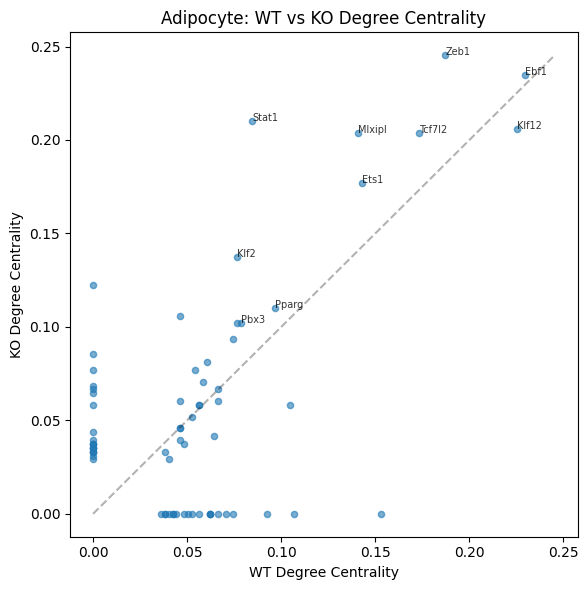

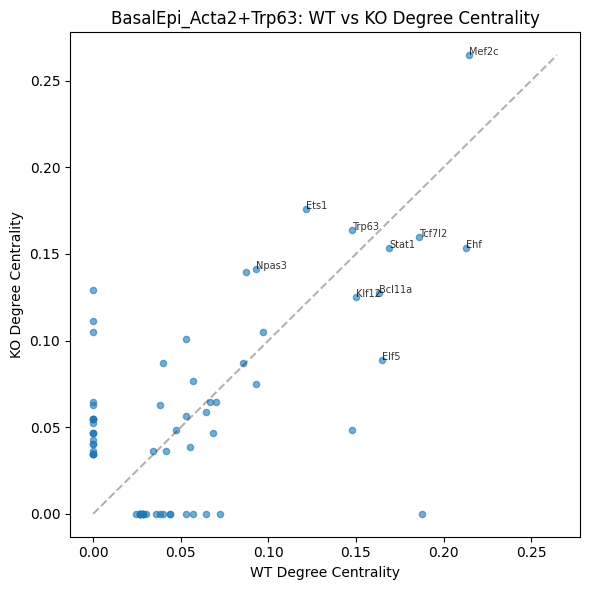

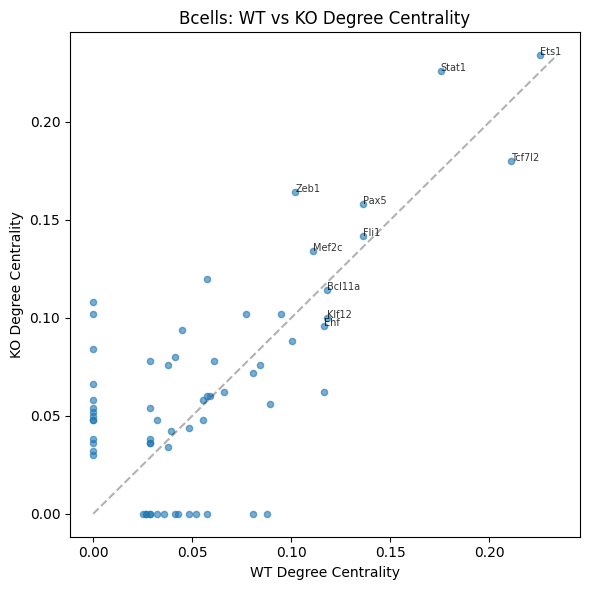

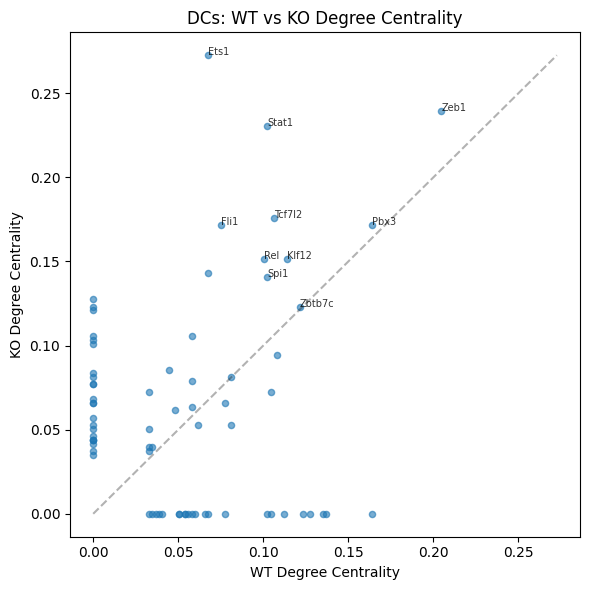

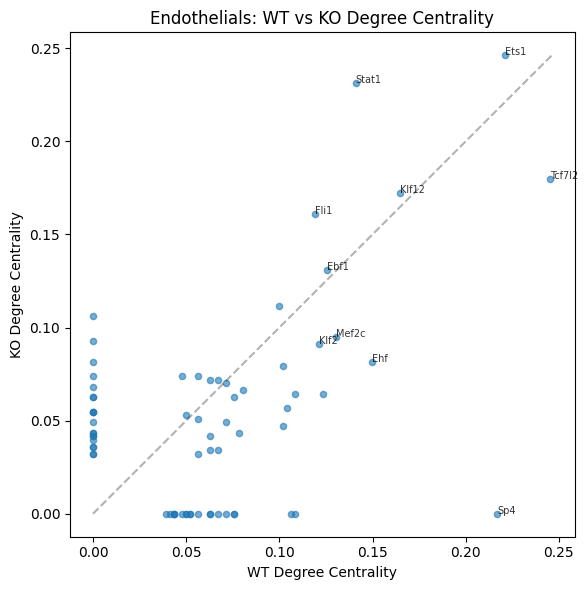

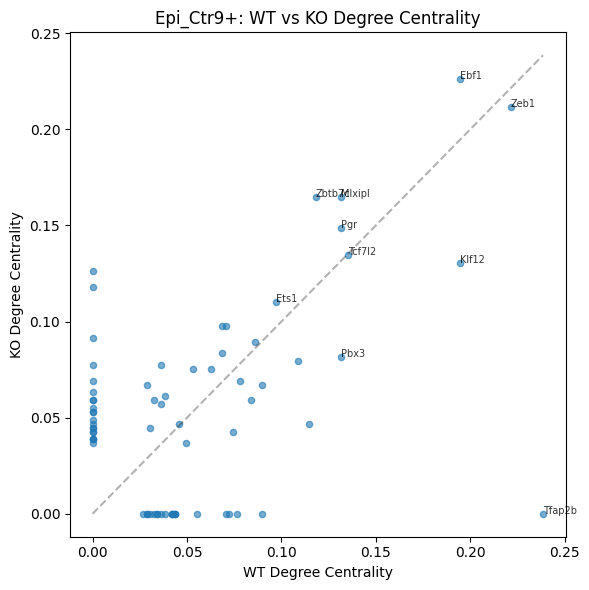

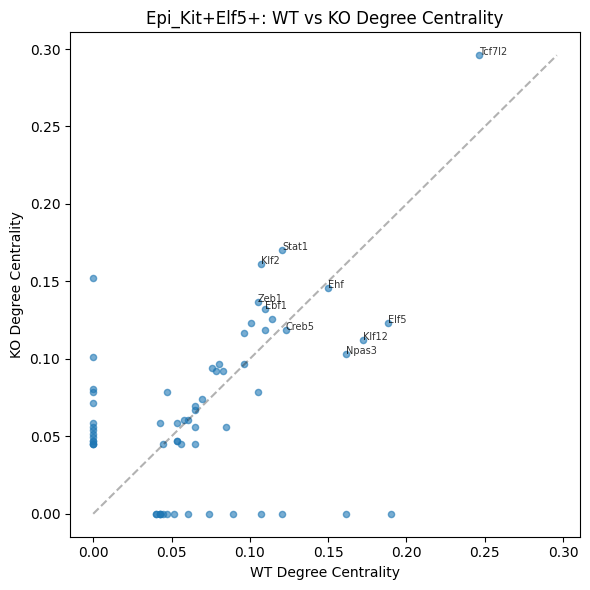

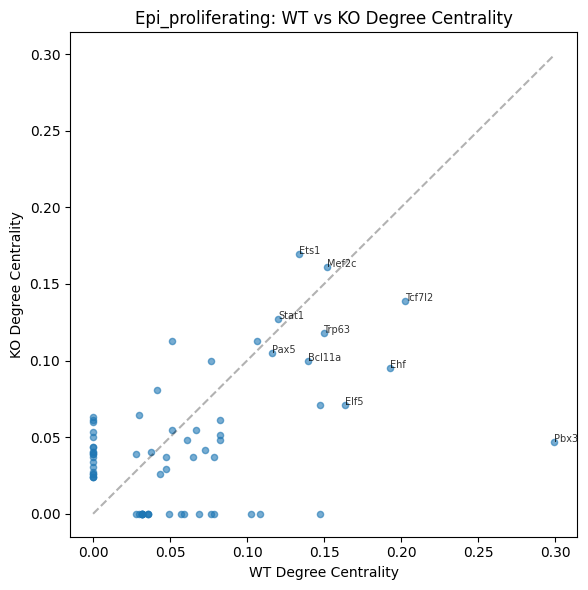

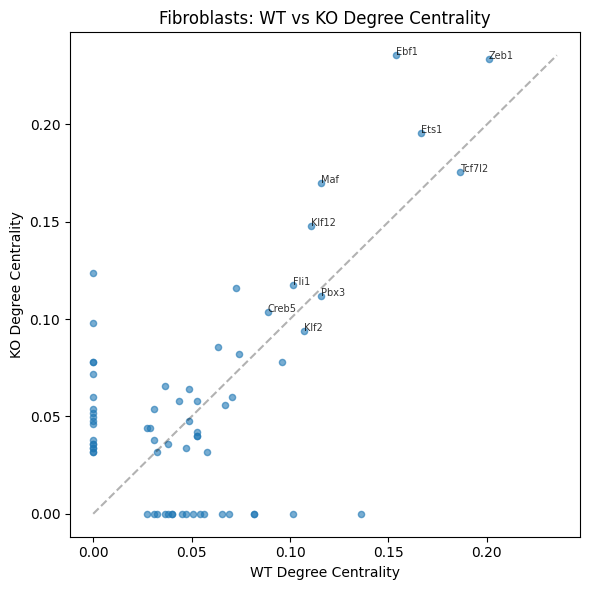

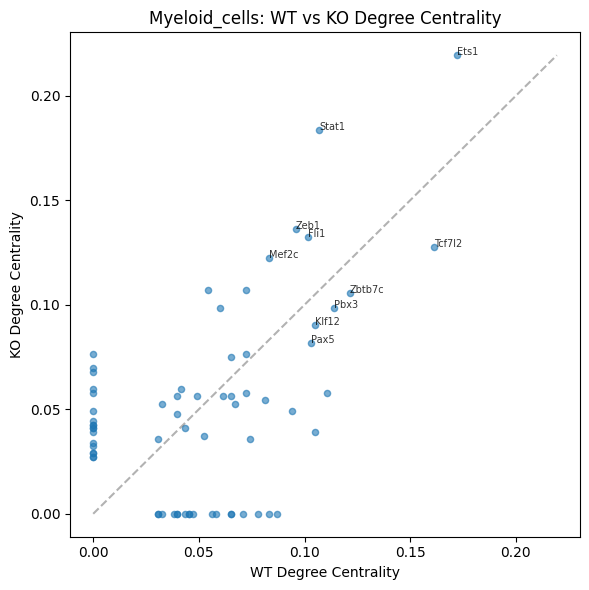

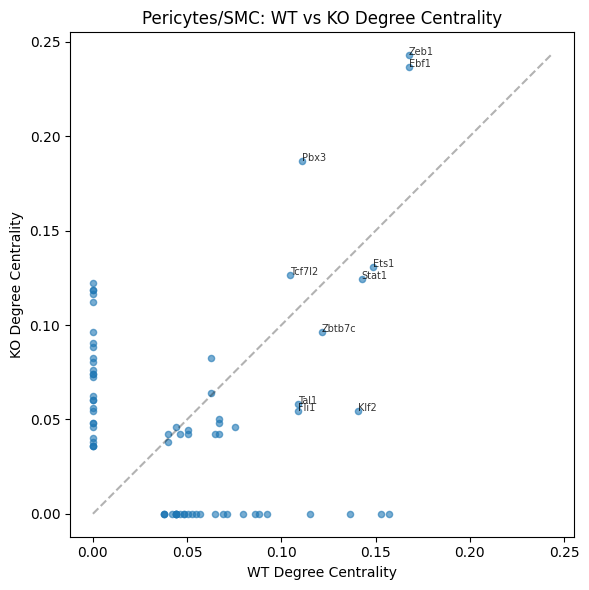

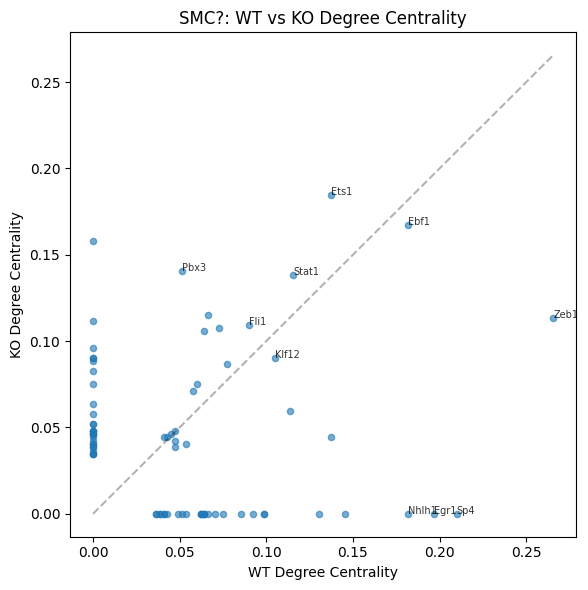

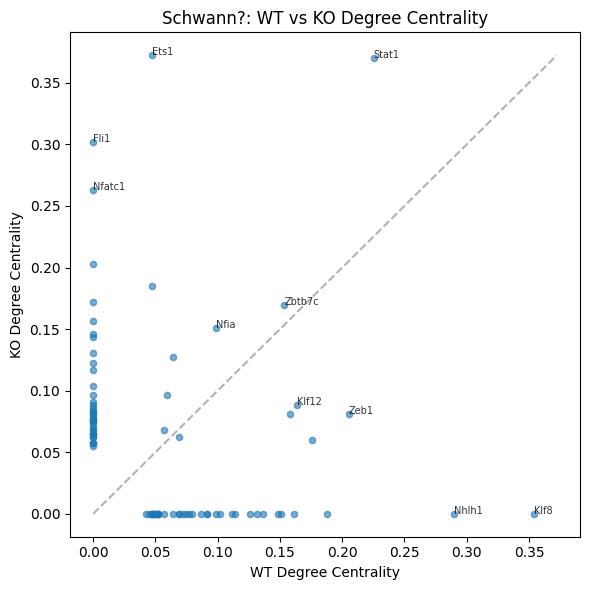

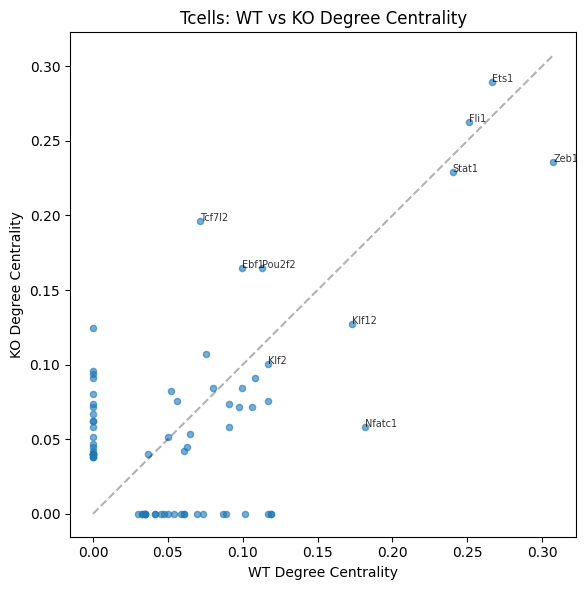

In [12]:
for ct in ko_cell_types:
    
    ko_ct = ko_dc[ko_dc['cell_type'] == ct].set_index('gene')['degree_centrality_all']
    wt_ct = wt_dc[wt_dc['cell_type'] == ct].set_index('gene')['degree_centrality_all']
    
    # Get union of genes from both conditions
    common_genes = ko_ct.index.union(wt_ct.index)
    
    # Align on common genes, fill missing with 0
    ko_vals = ko_ct.reindex(common_genes, fill_value=0)
    wt_vals = wt_ct.reindex(common_genes, fill_value=0)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(wt_vals, ko_vals, alpha=0.6, s=20)
    
    # Label top genes (highest in either condition)
    top_genes = (ko_vals + wt_vals).nlargest(10).index
    for g in top_genes:
        ax.annotate(g, (wt_vals[g], ko_vals[g]), fontsize=7, alpha=0.8)
    
    # Add diagonal reference line
    max_val = max(wt_vals.max(), ko_vals.max())
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)
    
    ax.set_xlabel('WT Degree Centrality')
    ax.set_ylabel('KO Degree Centrality')
    ax.set_title(f'{ct}: WT vs KO Degree Centrality')
    plt.tight_layout()
    safe_name = ct.replace("/", "_")
    plt.savefig(f"ko_wt_dc_comparison/{safe_name}.png", dpi=150)
    plt.show()